In [1]:
""" Import packages """
import os
from datetime import datetime
import pickle
import sys
import logging
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '../scripts/')

logging.basicConfig(filename='../logs/modeling.log', filemode='a',
                    encoding='utf-8', level=logging.DEBUG)

warnings.filterwarnings("ignore")

In [2]:
from mathematical_model import SIRVD
from mathematical_model import PredictionFromSIVRDGeneration

2023-10-06 07:51:35.434154: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 07:51:44.926633: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-06 07:51:56.751114: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
from explorer import DataTransformer
from utils_plots import EDAPlots

transformer = DataTransformer() 
plotmaker = EDAPlots()

In [4]:
REPO = "../"
filepath = "data/cleaned/study_dataset.csv"
rev = "Cleaneddatav22mf"

In [5]:
data = transformer.load_data(ext="csv", filepath=filepath, repo=REPO, rev=rev, header=0, parse_dates=["Date"])
data.head()

,ISO3,Date,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Feature_1,...,Feature_14,Feature_17,Feature_19,Feature_22,Feature_24,Feature_27,Feature_31,Feature_32,Feature_33,Feature_34
0,BFA,2000-12-31,603.210999,235.128065,874.845987,25.571181,62.627879,450.176799,717.149334,2.55,...,0.098126,856.4,26.376096,178.7,2.983886,85.40,6.857565,0,0,0
1,BFA,2001-12-31,601.937744,256.009859,918.916428,27.686540,66.619251,469.845175,876.388458,2.97,...,0.087891,967.8,26.193348,174.7,3.040729,85.49,6.867020,0,0,0
2,BFA,2002-12-31,595.852051,260.730606,958.846796,29.485652,72.230232,505.134949,743.621255,2.90,...,0.083175,942.7,26.010599,170.2,3.074790,85.43,6.874386,0,0,0
3,BFA,2003-12-31,585.123291,271.081041,965.412955,29.644367,72.615529,508.274478,881.413820,2.60,...,0.081205,996.3,25.827851,165.0,3.104518,85.30,6.865103,0,0,0
4,BFA,2004-12-31,562.411316,264.250419,925.186169,27.621911,71.165711,498.971133,873.945620,3.00,...,0.077845,940.7,25.645102,159.1,3.138021,85.31,6.873132,0,0,0


In [6]:
nga = data[data["ISO3"] == "NGA"]

In [7]:
index_cols = ["ISO3", "Date"]
target_columns = [col for col in data.columns if col.startswith("Target")]
input_columns = [col for col in data.columns if col.startswith("Feature")] + target_columns
feature_columns = [col for col in data.columns if col.startswith("Feature")]

In [8]:
targets_dict = {
    "Target_1": "Malaria Cases (per 1000)",
    "Target_2": "Malaria Deaths (per 1000)",
    "Target_3": "Malaria Deaths <5 Years Old (per 1000)",
    "Target_4": "Malaria Deaths 5-14 Years Old (per 1000)",
    "Target_5": "Malaria Deaths 15-49 Years Old (per 1000)",
    "Target_6": "Malaria Deaths 50-69 Years Old (per 1000)",
    "Target_7": "Malaria Deaths 70+ Years Old (per 1000)"
}

### Computing age group weights

In [9]:
mean_values = nga[target_columns[2:]].describe().loc["mean"].values
mean_overall_value = nga[["Target_2"]].describe().loc["mean"].values
mean_overall_value_converted = 5 * mean_overall_value
weights = mean_values / mean_overall_value_converted 

In [10]:
weights

array([0.67053726, 0.02952054, 0.05917298, 0.35922919, 0.64169273])

### Mathematical model SIVD-type

### Prepare Plausible Observed Data in I and D

In [11]:
# observed_rates_dataframe = nga[["Target_1", "Target_2"]]

In [12]:
# plausible_observed_I_and_D = sirvdModel.get_plausible_observations(observed_rates_dataframe)

### Parameter optimization

In [13]:
# # Initial conditions
# y0 = [
#     1000000, # S
#     plausible_observed_I_and_D[0, 0], # I 
#     0, # R
#     0, # V
#     plausible_observed_I_and_D[0, 1] # D
# ]

# # Time period
# t = np.arange(0, 23)

In [14]:
# optimized_params = sirvdModel.optimize_params(y0, t, plausible_observed_I_and_D)

In [15]:
# optimized_params

### Generation and Prediction

In [16]:
nga.tail(1)

,ISO3,Date,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Feature_1,...,Feature_14,Feature_17,Feature_19,Feature_22,Feature_24,Feature_27,Feature_31,Feature_32,Feature_33,Feature_34
114,NGA,2022-12-31,305.968876,107.272681,256.320284,15.015838,33.303575,198.031753,499.604965,61.766261,...,0.094556,1667.023817,23.444199,108.321836,2.380007,82.203028,3.838623,0,0,0


In [17]:
S_0 = 1000000
I_0 = int((305.968876/1000) * S_0)
D_0 = int((107.272681/1000) * I_0)
y0 = [
    S_0, # S
    I_0, # I
    0, # R
    0, # V
    D_0 # D
]

In [18]:
S_0, I_0, D_0

(1000000, 305968, 32822)

In [19]:
predEssential = PredictionFromSIVRDGeneration()

### Scenario 1 - theta=0.3, tau=0.3

In [20]:
# Initial guess for parameters
params_for_gen = [
    1/70, # Lambda
    0.0044*365, # lambda
    0.3, # theta
    0.665, # omega_v
    0.005*365, # omega_r
    0.0003*52, # mu 
    0.3, # tau
    0.0027*365, # gamma
    0.00105 # delta
]

sirvdModel = SIRVD(params=params_for_gen)

In [21]:
feature_32 = 1
feature_33 = 1
feature_34 = 0

In [22]:
t_pred = np.arange(23, 73)

In [23]:
# params_for_gen = [
#     68088 * 52, # Lambda
#     0.353339067, # lambda
#     0.8, # theta
#     0.6, # omega_v
#     4.015, # omega_r
#     0.0003*52, # mu
#     0.8, # tau
#     0.0027*365, # gamma
#     0.143734082 # delta
# ]

# sirvdModel.update_params(params_for_gen)

In [24]:
S, I, R, V, D = sirvdModel.estimate_classes_dynamics(y0, t_pred)

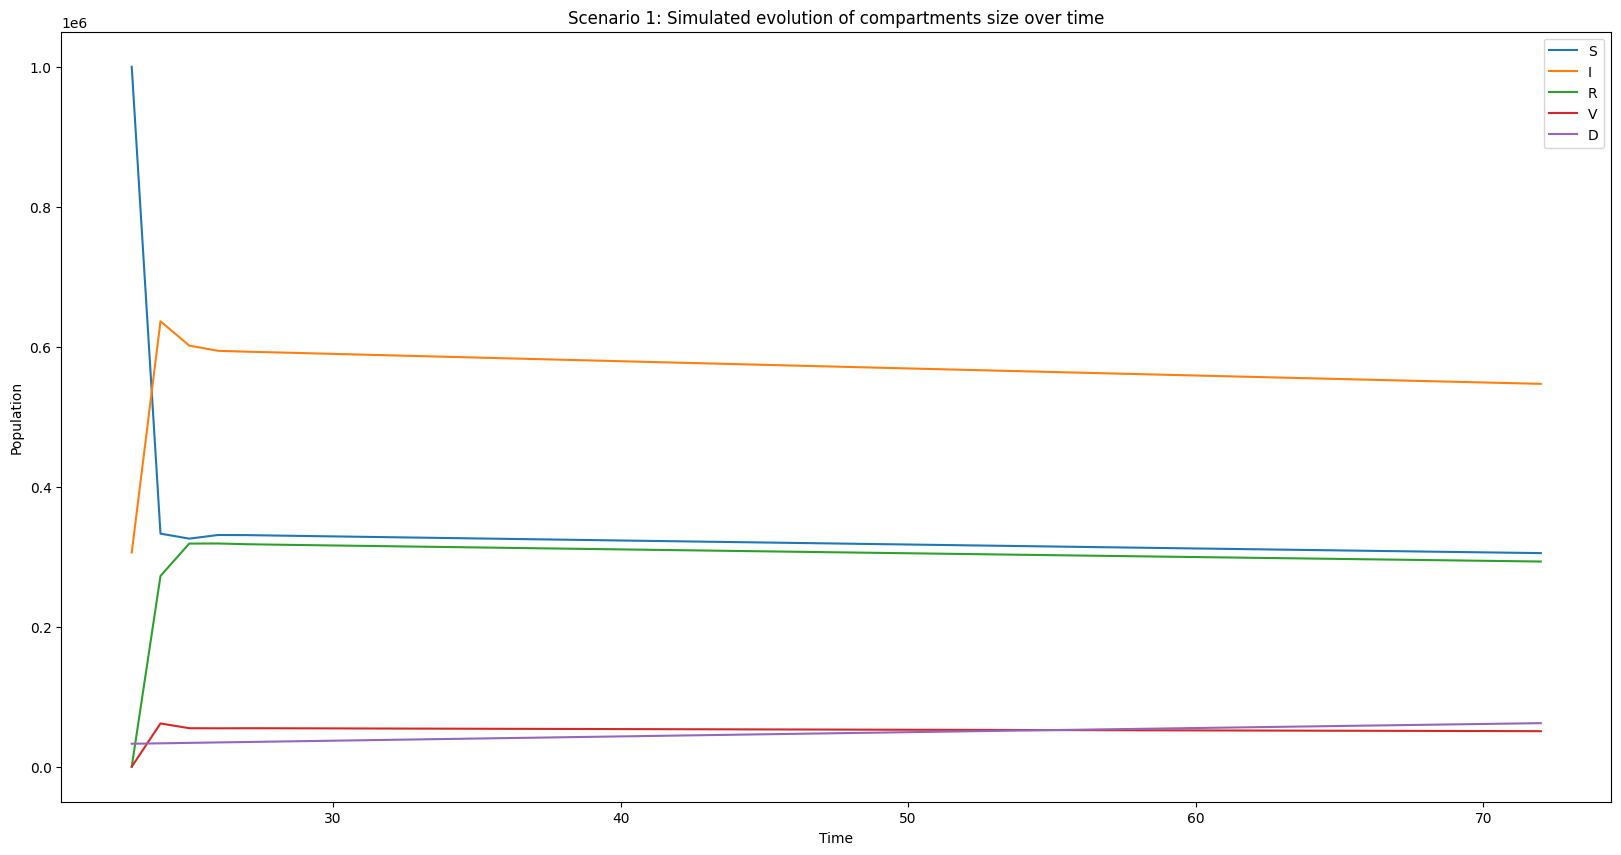

In [25]:
compartments = {
    "S": S,
    "I": I,
    "R": R,
    "V": V,
    "D": D
}

plotmaker.sirvd_dynamics(t_pred, compartments, for_scenario=1)

In [26]:
pred_data = sirvdModel.get_corresponding_targets_values(solutions=[S, I, R, V, D], weights=weights, target_columns=target_columns)

In [27]:
scenario_input_data = predEssential.get_model_inputs_data(
    data=nga, 
    feature_columns=feature_columns, 
    pred_data=pred_data, 
    feature_32=feature_32, 
    feature_33=feature_33, 
    feature_34=feature_34
)

In [28]:
total_predicted_data = predEssential.predict_scenario(
    data=scenario_input_data,
    nga_data=nga,
    input_columns=input_columns,
    index_cols=index_cols,
    target_columns=target_columns
)

2/2 [==============================] - 3s 49ms/step


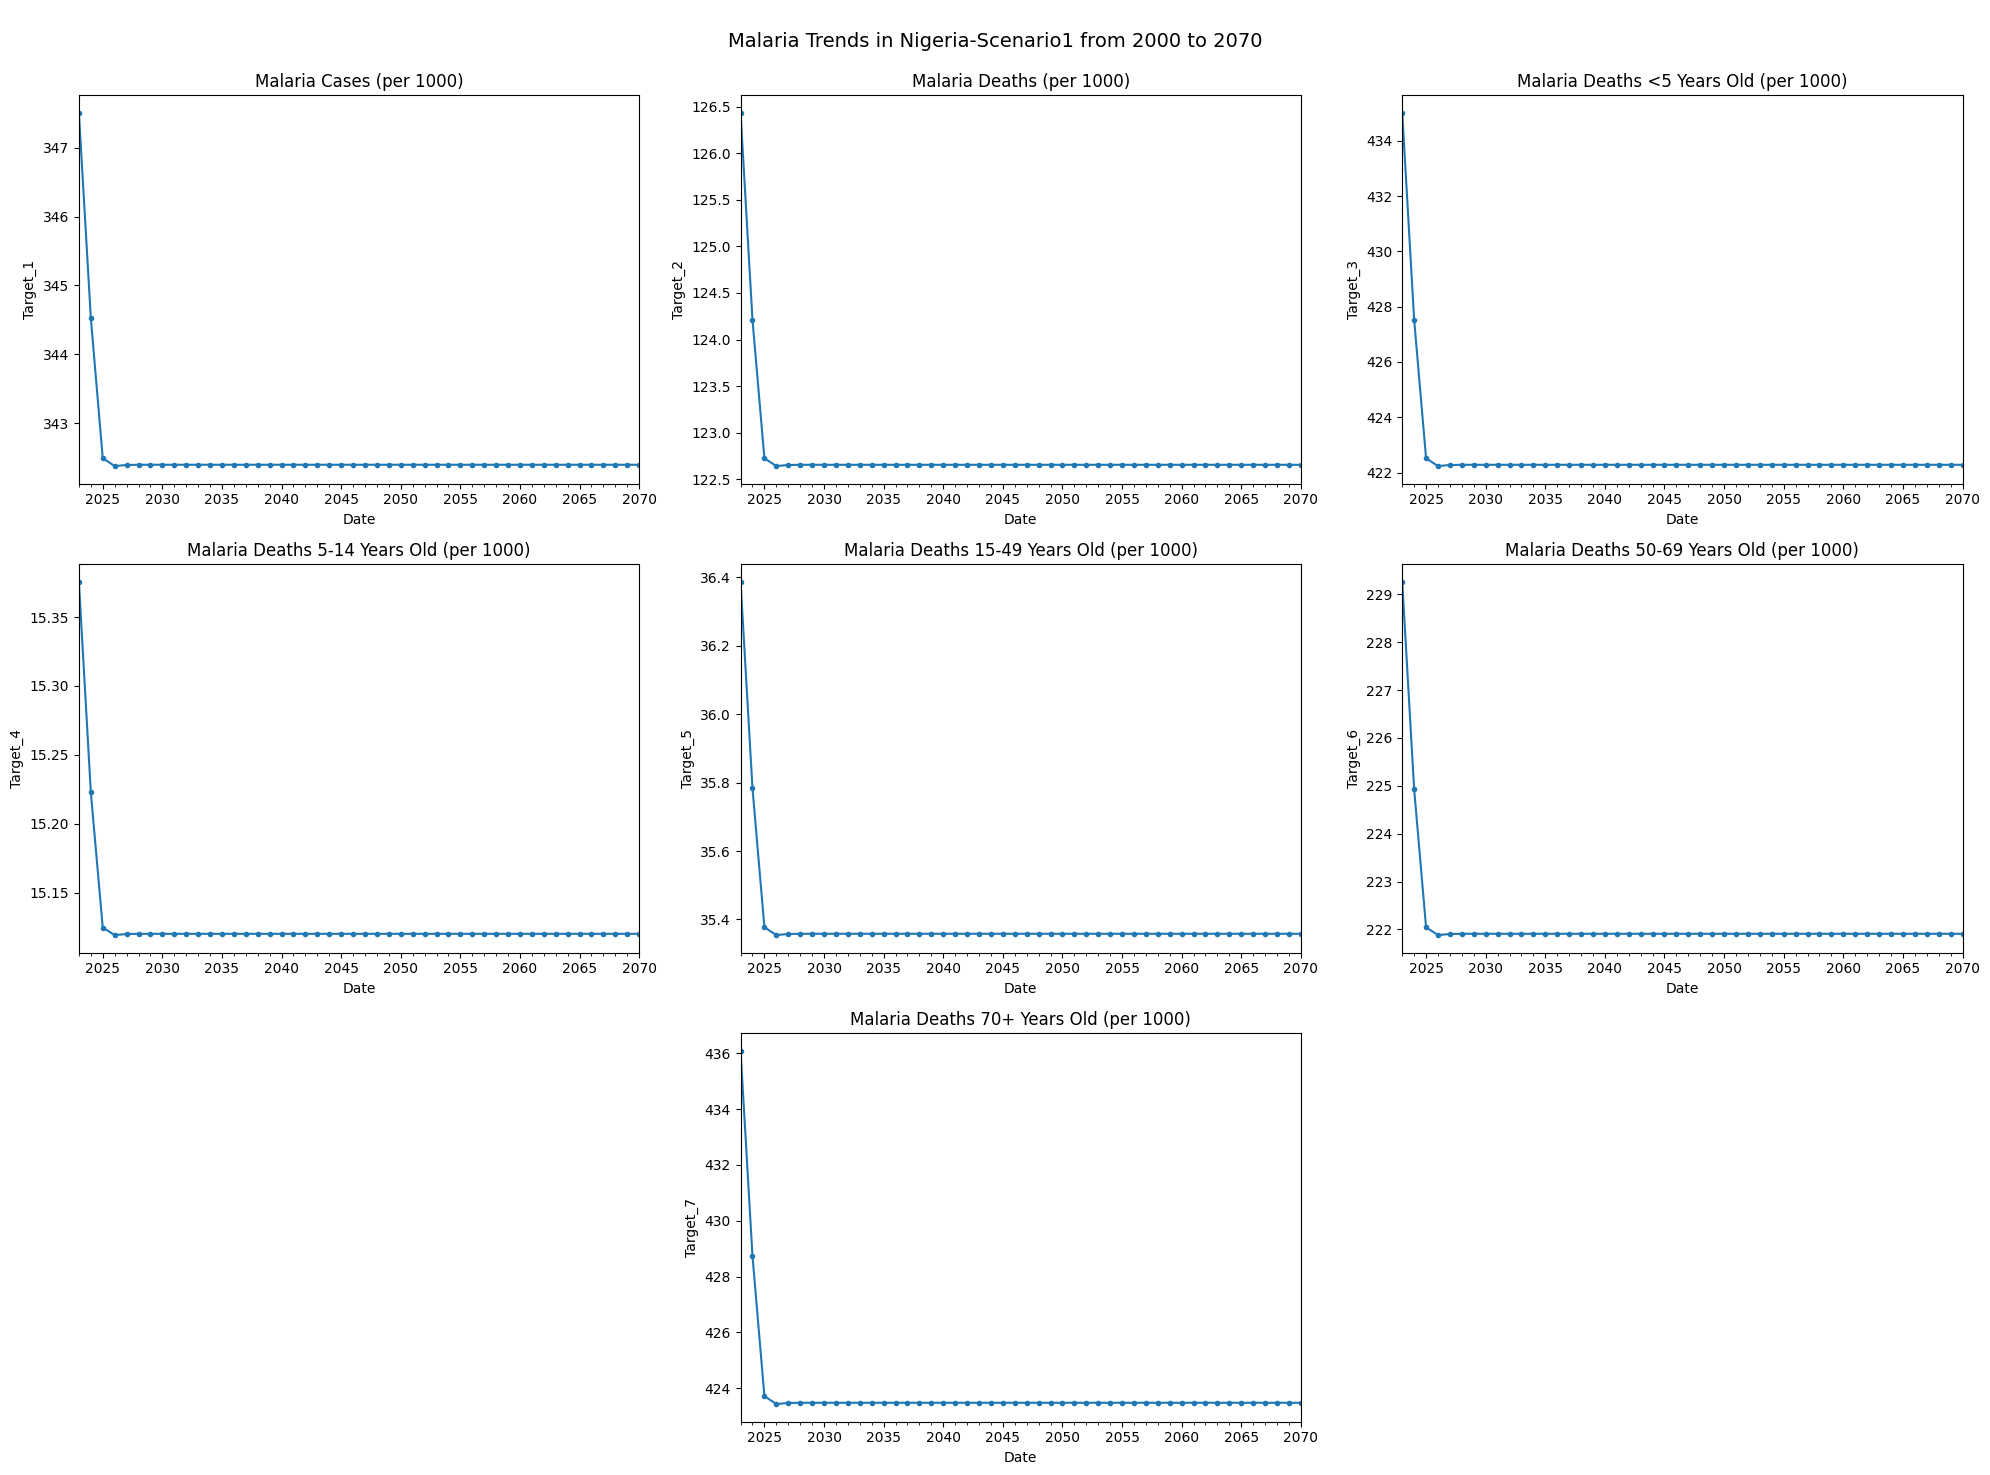

In [29]:
plotmaker.serve_country_predictions(
    data=total_predicted_data[total_predicted_data.Predicted == 1], 
    country="Nigeria-Scenario1",
    targets_list = list(targets_dict.keys()) ,
    target_names = list(targets_dict.values()),
    nrows=3,
    ncols=3, 
    figsize=(20, 15), 
    nfigs=7, 
    centered=True
)

In [30]:
total_predicted_data.loc[["2023-12-31", "2070-12-31"]][target_columns].pct_change()

,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7
2023-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2070-12-31,-0.014699,-0.029887,-0.029243,-0.016612,-0.028273,-0.032066,-0.028911


### Scenario 2 - theta=0.3, tau=0.77

In [31]:
# Initial guess for parameters
params_for_gen = [
    1/70, # Lambda
    0.0044*365, # lambda
    0.3, # theta
    0.665, # omega_v
    0.005*365, # omega_r
    0.0003*52, # mu 
    0.77, # tau
    0.0027*365, # gamma
    0.00105 # delta
]

sirvdModel = SIRVD(params=params_for_gen)

In [32]:
feature_32 = 0
feature_33 = 0
feature_34 = 1

In [33]:
t_pred = np.arange(23, 73)

In [34]:
# params_for_gen = [
#     68088 * 52, # Lambda
#     0.353339067, # lambda
#     0.8, # theta
#     0.6, # omega_v
#     4.015, # omega_r
#     0.0003*52, # mu
#     0.8, # tau
#     0.0027*365, # gamma
#     0.143734082 # delta
# ]

# sirvdModel.update_params(params_for_gen)

In [35]:
S, I, R, V, D = sirvdModel.estimate_classes_dynamics(y0, t_pred)

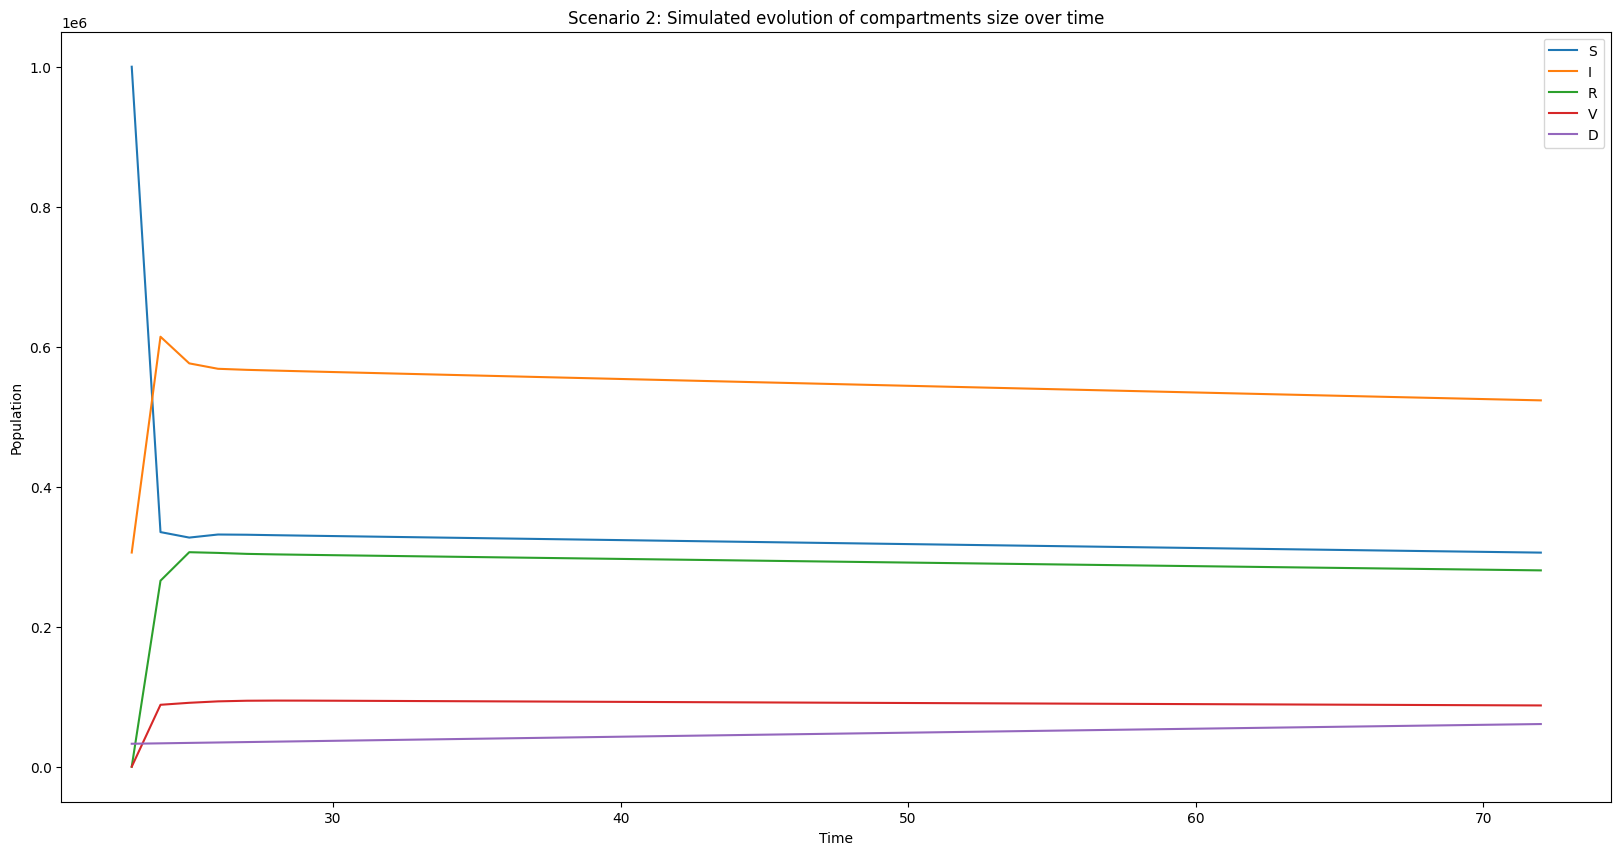

In [37]:
compartments = {
    "S": S,
    "I": I,
    "R": R,
    "V": V,
    "D": D
}

plotmaker.sirvd_dynamics(t_pred, compartments, for_scenario=2)

In [38]:
pred_data = sirvdModel.get_corresponding_targets_values(solutions=[S, I, R, V, D], weights=weights, target_columns=target_columns)

In [39]:
scenario_input_data = predEssential.get_model_inputs_data(
    data=nga, 
    feature_columns=feature_columns, 
    pred_data=pred_data, 
    feature_32=feature_32, 
    feature_33=feature_33, 
    feature_34=feature_34
)

In [40]:
total_predicted_data = predEssential.predict_scenario(
    data=scenario_input_data,
    nga_data=nga,
    input_columns=input_columns,
    index_cols=index_cols,
    target_columns=target_columns
)

2/2 [==============================] - 0s 8ms/step


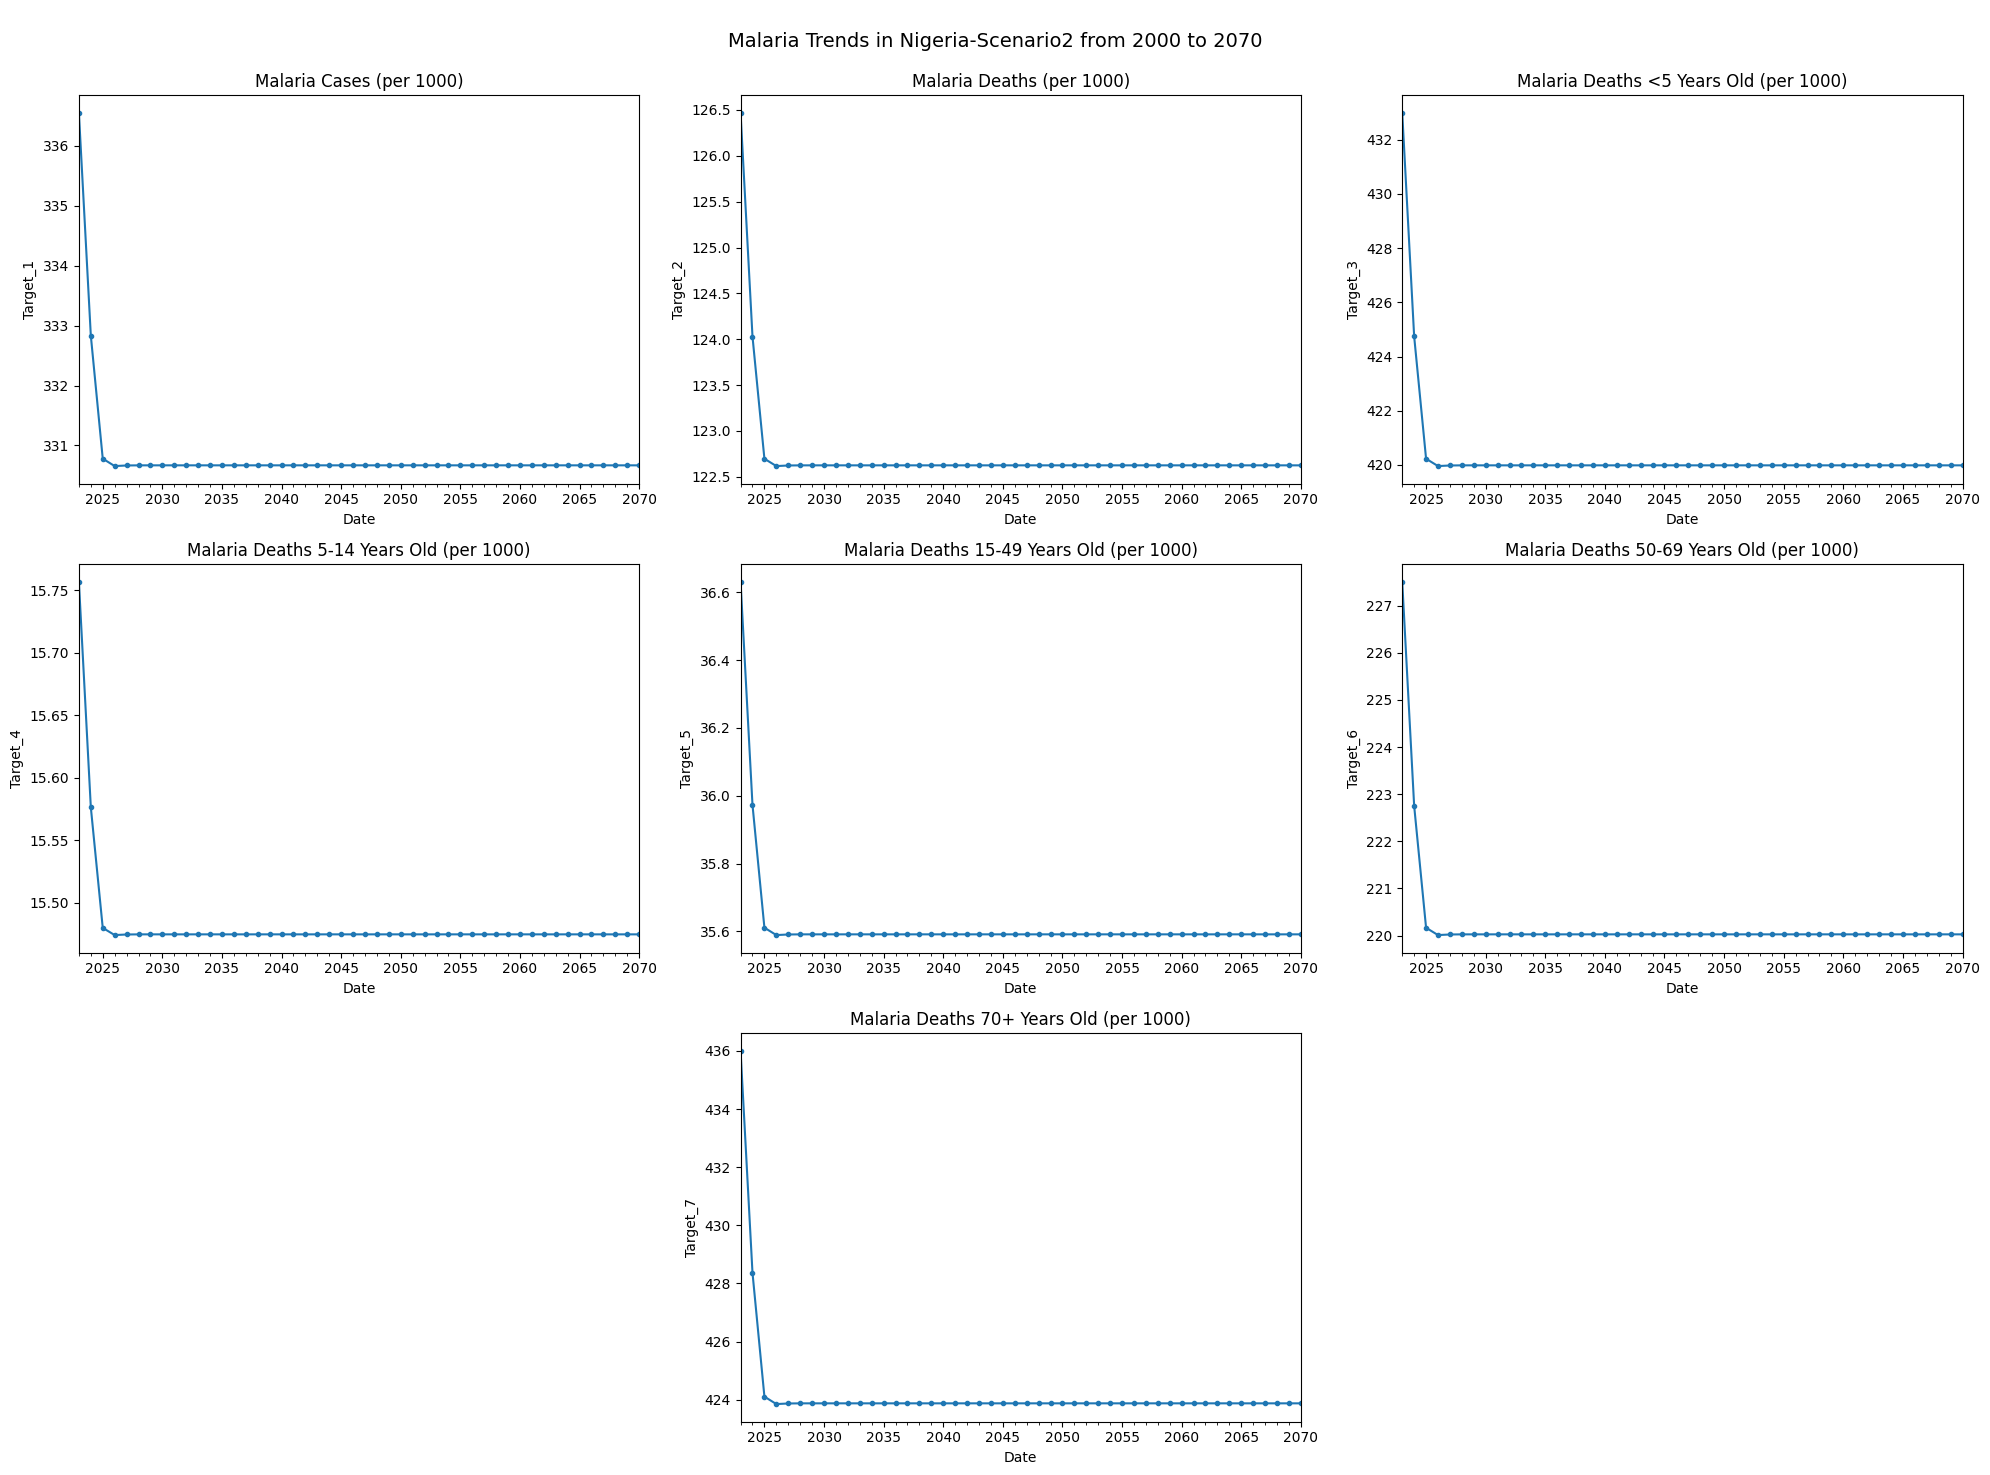

In [41]:
plotmaker.serve_country_predictions(
    data=total_predicted_data[total_predicted_data.Predicted == 1], 
    country="Nigeria-Scenario2",
    targets_list = list(targets_dict.keys()) ,
    target_names = list(targets_dict.values()),
    nrows=3,
    ncols=3, 
    figsize=(20, 15), 
    nfigs=7, 
    centered=True
)

In [42]:
total_predicted_data.loc[["2023-12-31", "2070-12-31"]][target_columns].pct_change()

,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7
2023-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2070-12-31,-0.017472,-0.030381,-0.030023,-0.017893,-0.028361,-0.032871,-0.027801


### Scenario 3 - theta=0.8, tau=0.3

In [43]:
# Initial guess for parameters
params_for_gen = [
    1/70, # Lambda
    0.0044*365, # lambda
    0.8, # theta
    0.665, # omega_v
    0.005*365, # omega_r
    0.0003*52, # mu 
    0.3, # tau
    0.0027*365, # gamma
    0.00105 # delta
]

sirvdModel = SIRVD(params=params_for_gen)

In [44]:
feature_32 = 1
feature_33 = 1
feature_34 = 0

In [45]:
t_pred = np.arange(23, 73)

In [46]:
# params_for_gen = [
#     68088 * 52, # Lambda
#     0.353339067, # lambda
#     0.8, # theta
#     0.6, # omega_v
#     4.015, # omega_r
#     0.0003*52, # mu
#     0.8, # tau
#     0.0027*365, # gamma
#     0.143734082 # delta
# ]

# sirvdModel.update_params(params_for_gen)

In [47]:
S, I, R, V, D = sirvdModel.estimate_classes_dynamics(y0, t_pred)

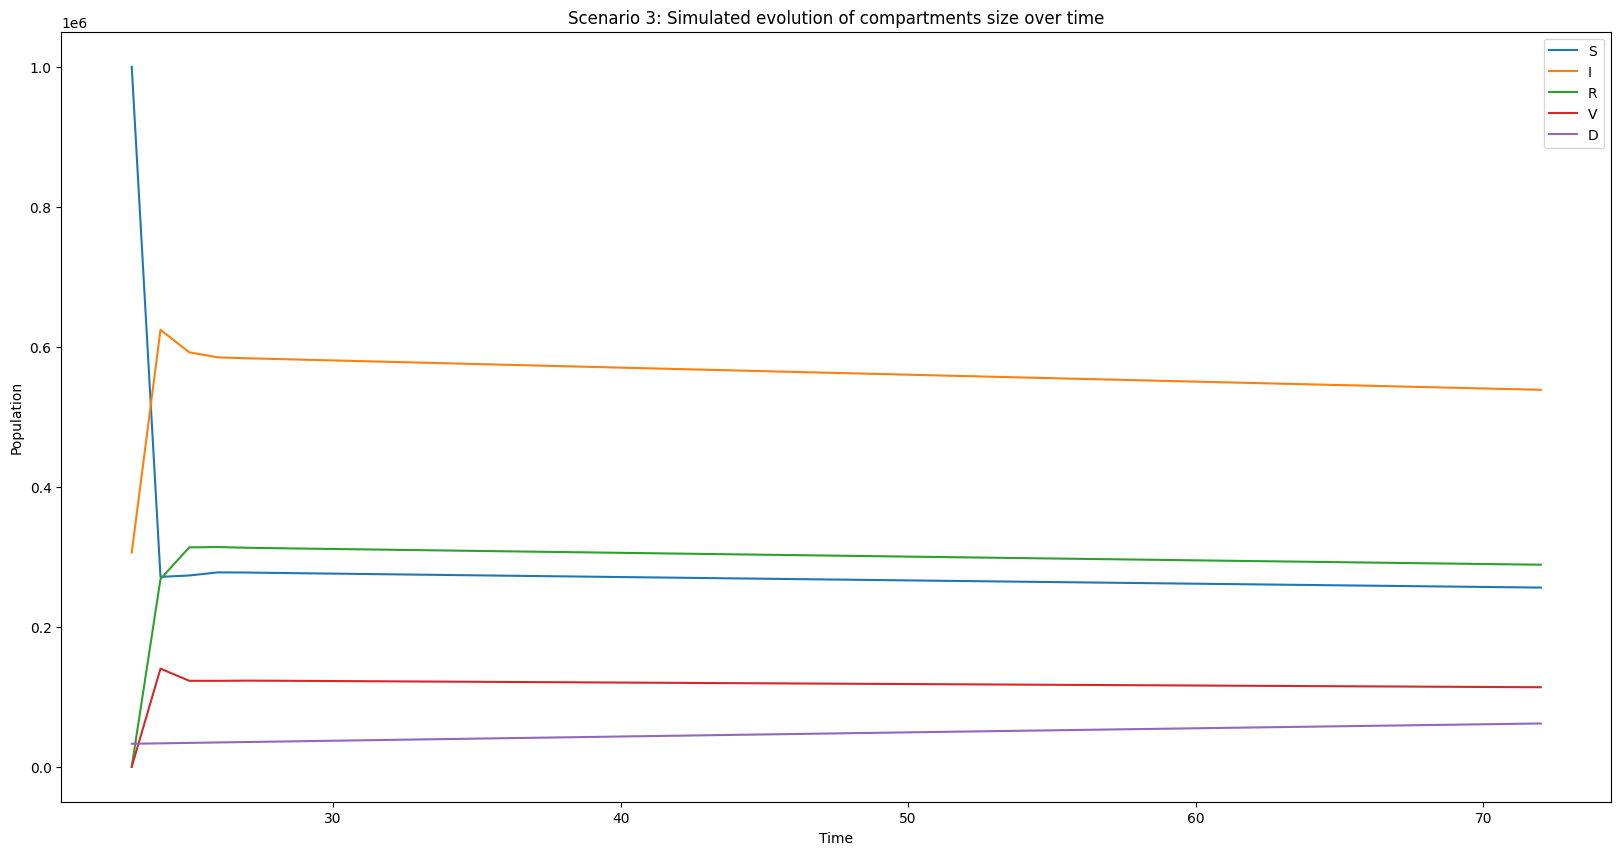

In [48]:
compartments = {
    "S": S,
    "I": I,
    "R": R,
    "V": V,
    "D": D
}

plotmaker.sirvd_dynamics(t_pred, compartments, for_scenario=3)

In [49]:
pred_data = sirvdModel.get_corresponding_targets_values(solutions=[S, I, R, V, D], weights=weights, target_columns=target_columns)

In [50]:
scenario_input_data = predEssential.get_model_inputs_data(
    data=nga, 
    feature_columns=feature_columns, 
    pred_data=pred_data, 
    feature_32=feature_32, 
    feature_33=feature_33, 
    feature_34=feature_34
)

In [51]:
total_predicted_data = predEssential.predict_scenario(
    data=scenario_input_data,
    nga_data=nga,
    input_columns=input_columns,
    index_cols=index_cols,
    target_columns=target_columns
)

2/2 [==============================] - 0s 9ms/step


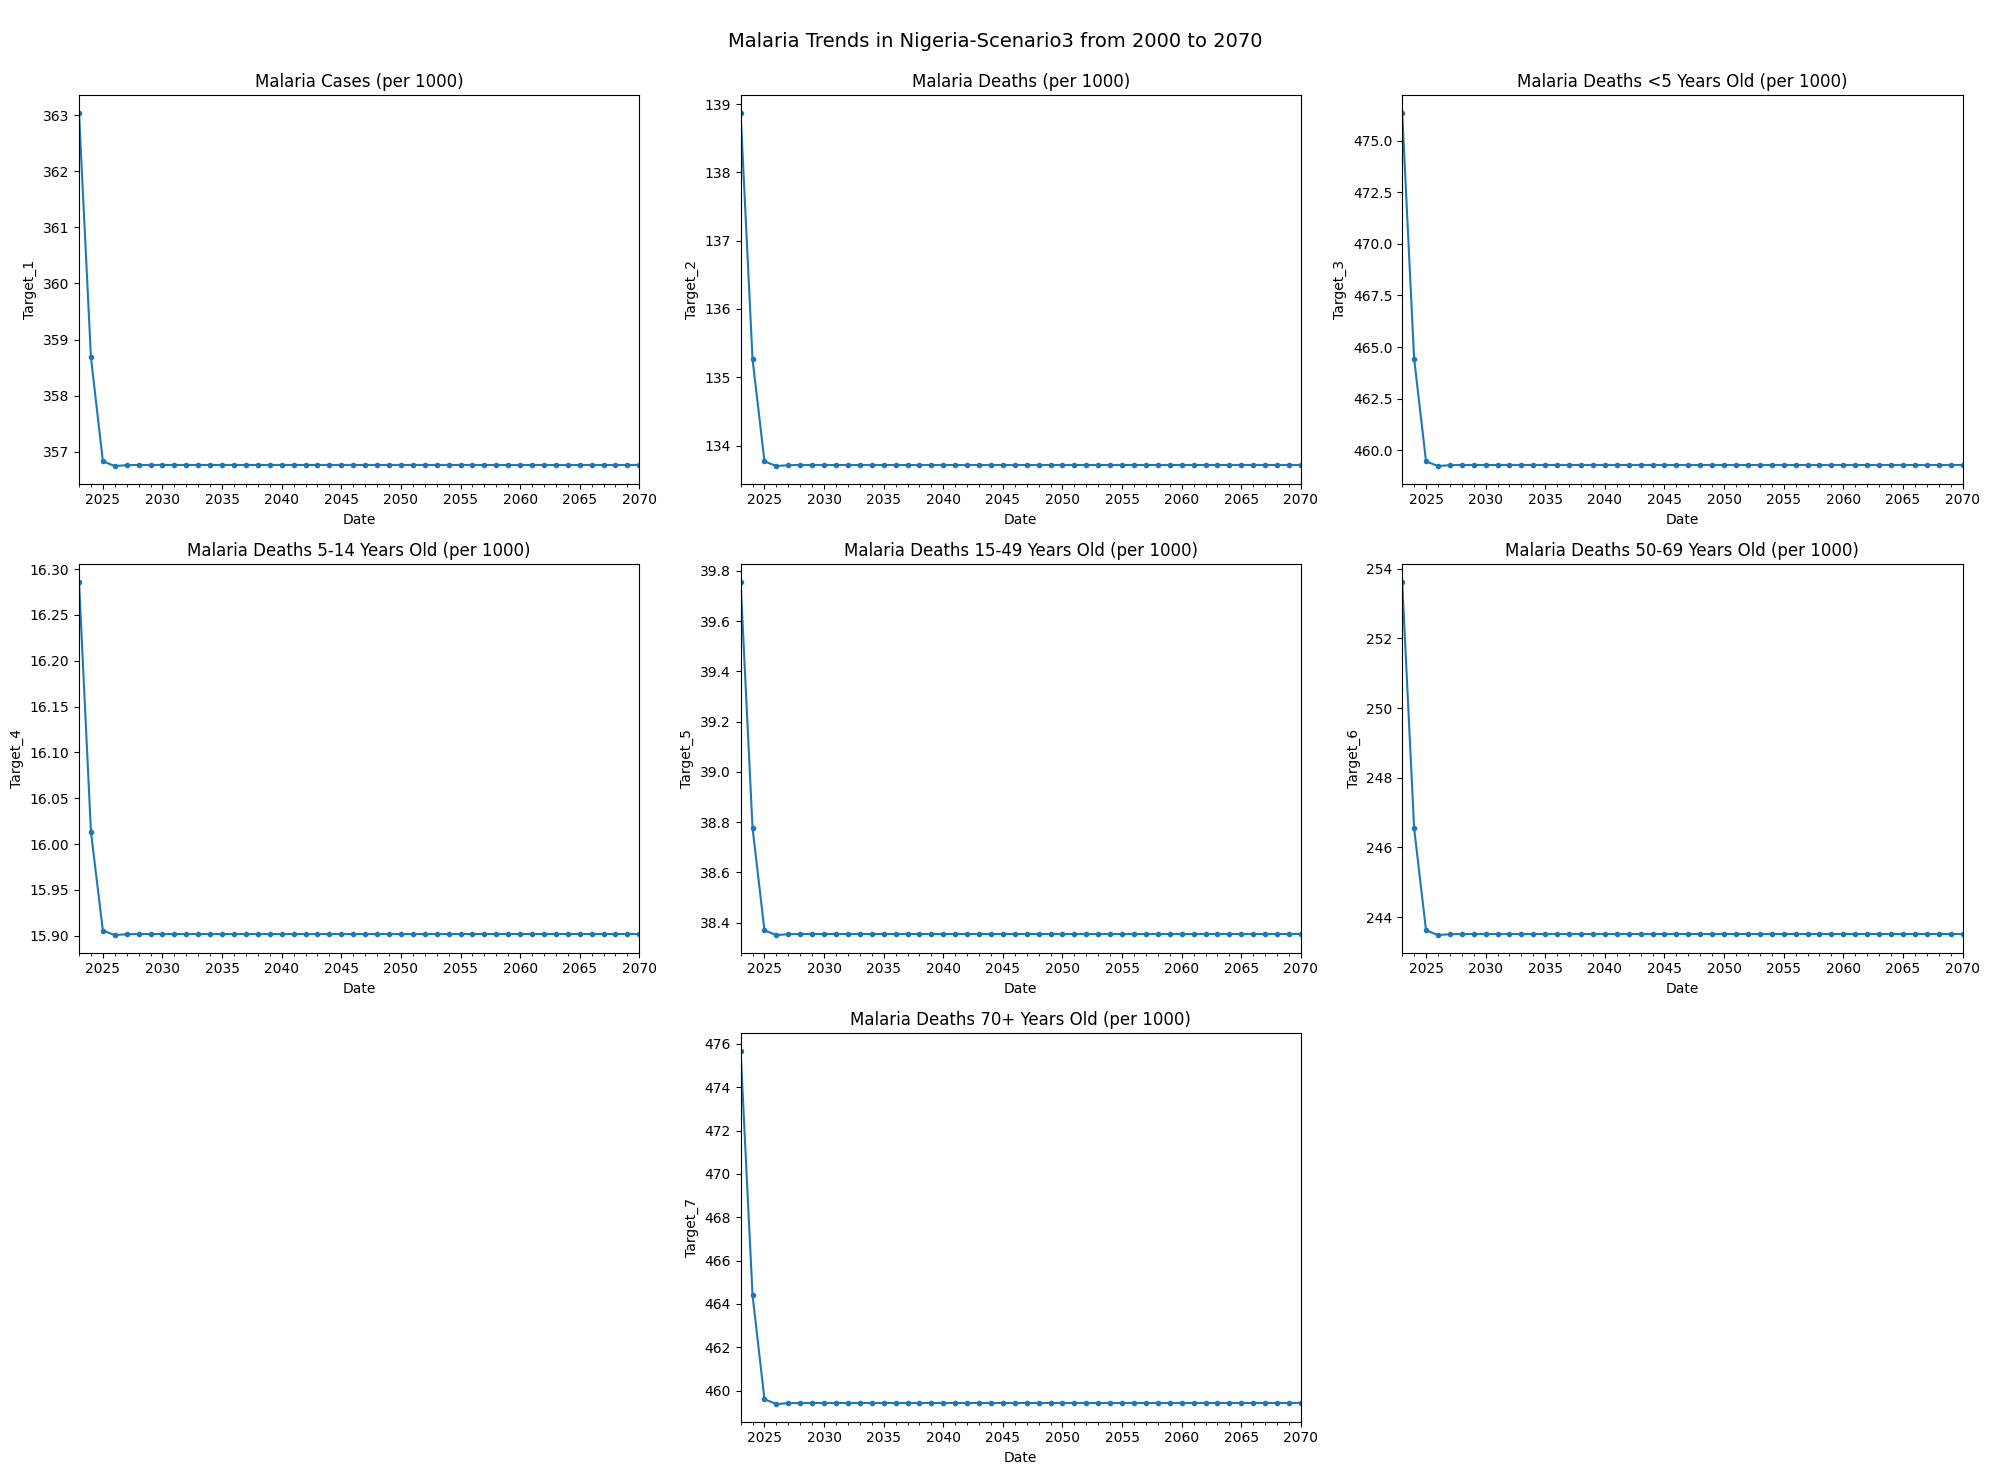

In [52]:
plotmaker.serve_country_predictions(
    data=total_predicted_data[total_predicted_data.Predicted == 1], 
    country="Nigeria-Scenario3",
    targets_list = list(targets_dict.keys()) ,
    target_names = list(targets_dict.values()),
    nrows=3,
    ncols=3, 
    figsize=(20, 15), 
    nfigs=7, 
    centered=True
)

In [53]:
total_predicted_data.loc[["2023-12-31", "2070-12-31"]][target_columns].pct_change()

,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7
2023-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2070-12-31,-0.017286,-0.037113,-0.03577,-0.023584,-0.035255,-0.03983,-0.034163


### Scenario 4 - theta=0.8, tau=0.77

In [54]:
# Initial guess for parameters
params_for_gen = [
    1/70, # Lambda
    0.0044*365, # lambda
    0.8, # theta
    0.665, # omega_v
    0.005*365, # omega_r
    0.0003*52, # mu 
    0.77, # tau
    0.0027*365, # gamma
    0.00105 # delta
]

sirvdModel = SIRVD(params=params_for_gen)

In [55]:
feature_32 = 0
feature_33 = 0
feature_34 = 1

In [56]:
t_pred = np.arange(23, 73)

In [57]:
# params_for_gen = [
#     68088 * 52, # Lambda
#     0.353339067, # lambda
#     0.8, # theta
#     0.6, # omega_v
#     4.015, # omega_r
#     0.0003*52, # mu
#     0.8, # tau
#     0.0027*365, # gamma
#     0.143734082 # delta
# ]

# sirvdModel.update_params(params_for_gen)

In [58]:
S, I, R, V, D = sirvdModel.estimate_classes_dynamics(y0, t_pred)

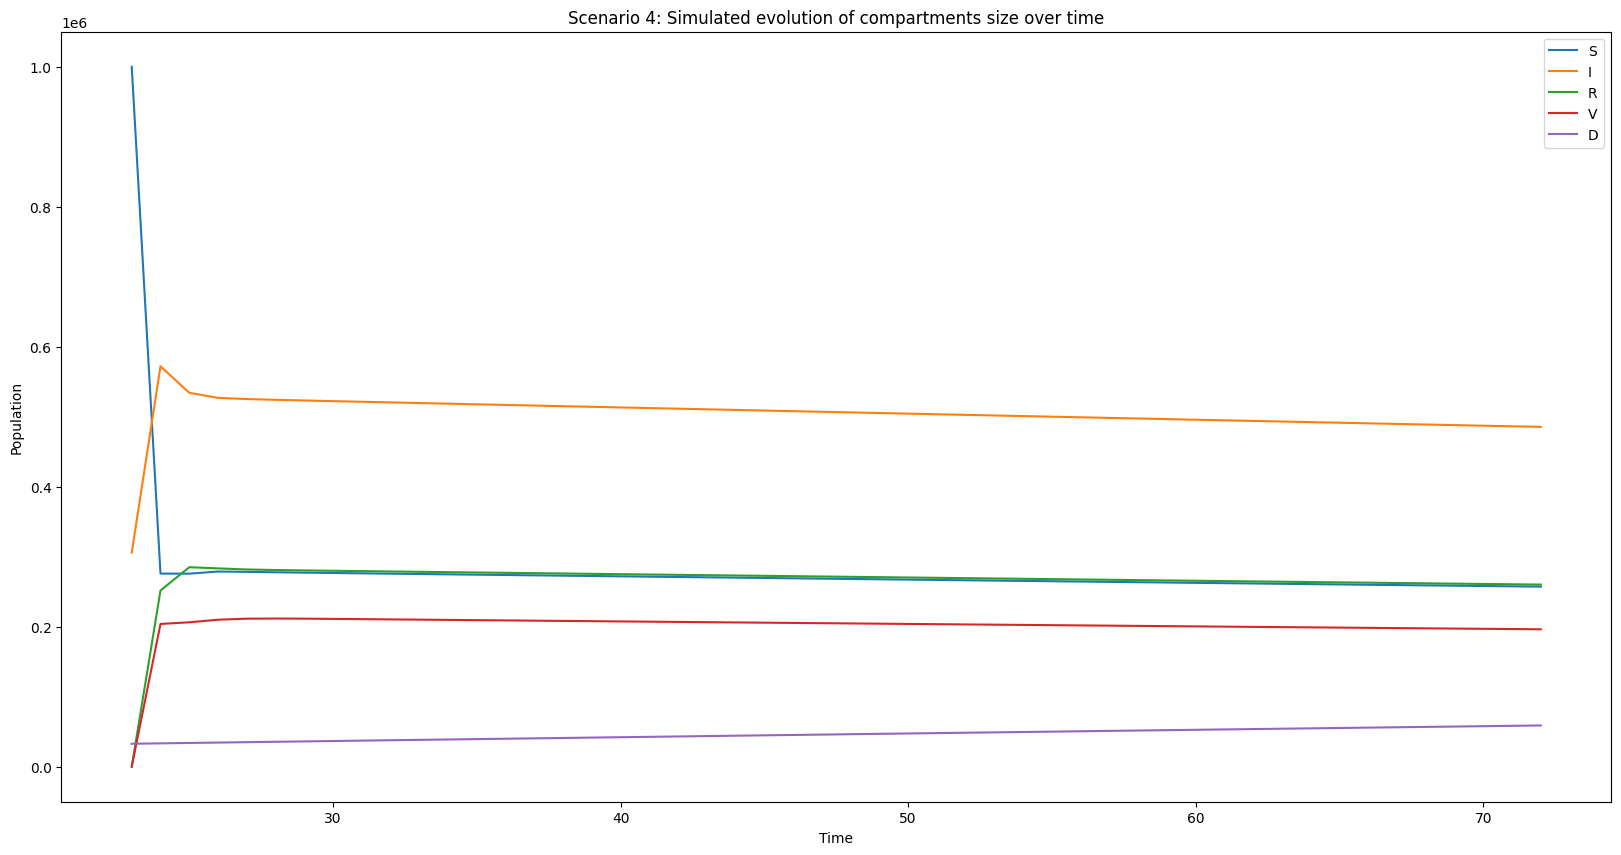

In [59]:
compartments = {
    "S": S,
    "I": I,
    "R": R,
    "V": V,
    "D": D
}

plotmaker.sirvd_dynamics(t_pred, compartments, for_scenario=4)

In [60]:
pred_data = sirvdModel.get_corresponding_targets_values(solutions=[S, I, R, V, D], weights=weights, target_columns=target_columns)

In [61]:
scenario_input_data = predEssential.get_model_inputs_data(
    data=nga, 
    feature_columns=feature_columns, 
    pred_data=pred_data, 
    feature_32=feature_32, 
    feature_33=feature_33, 
    feature_34=feature_34
)

In [62]:
total_predicted_data = predEssential.predict_scenario(
    data=scenario_input_data,
    nga_data=nga,
    input_columns=input_columns,
    index_cols=index_cols,
    target_columns=target_columns
)

2/2 [==============================] - 0s 8ms/step


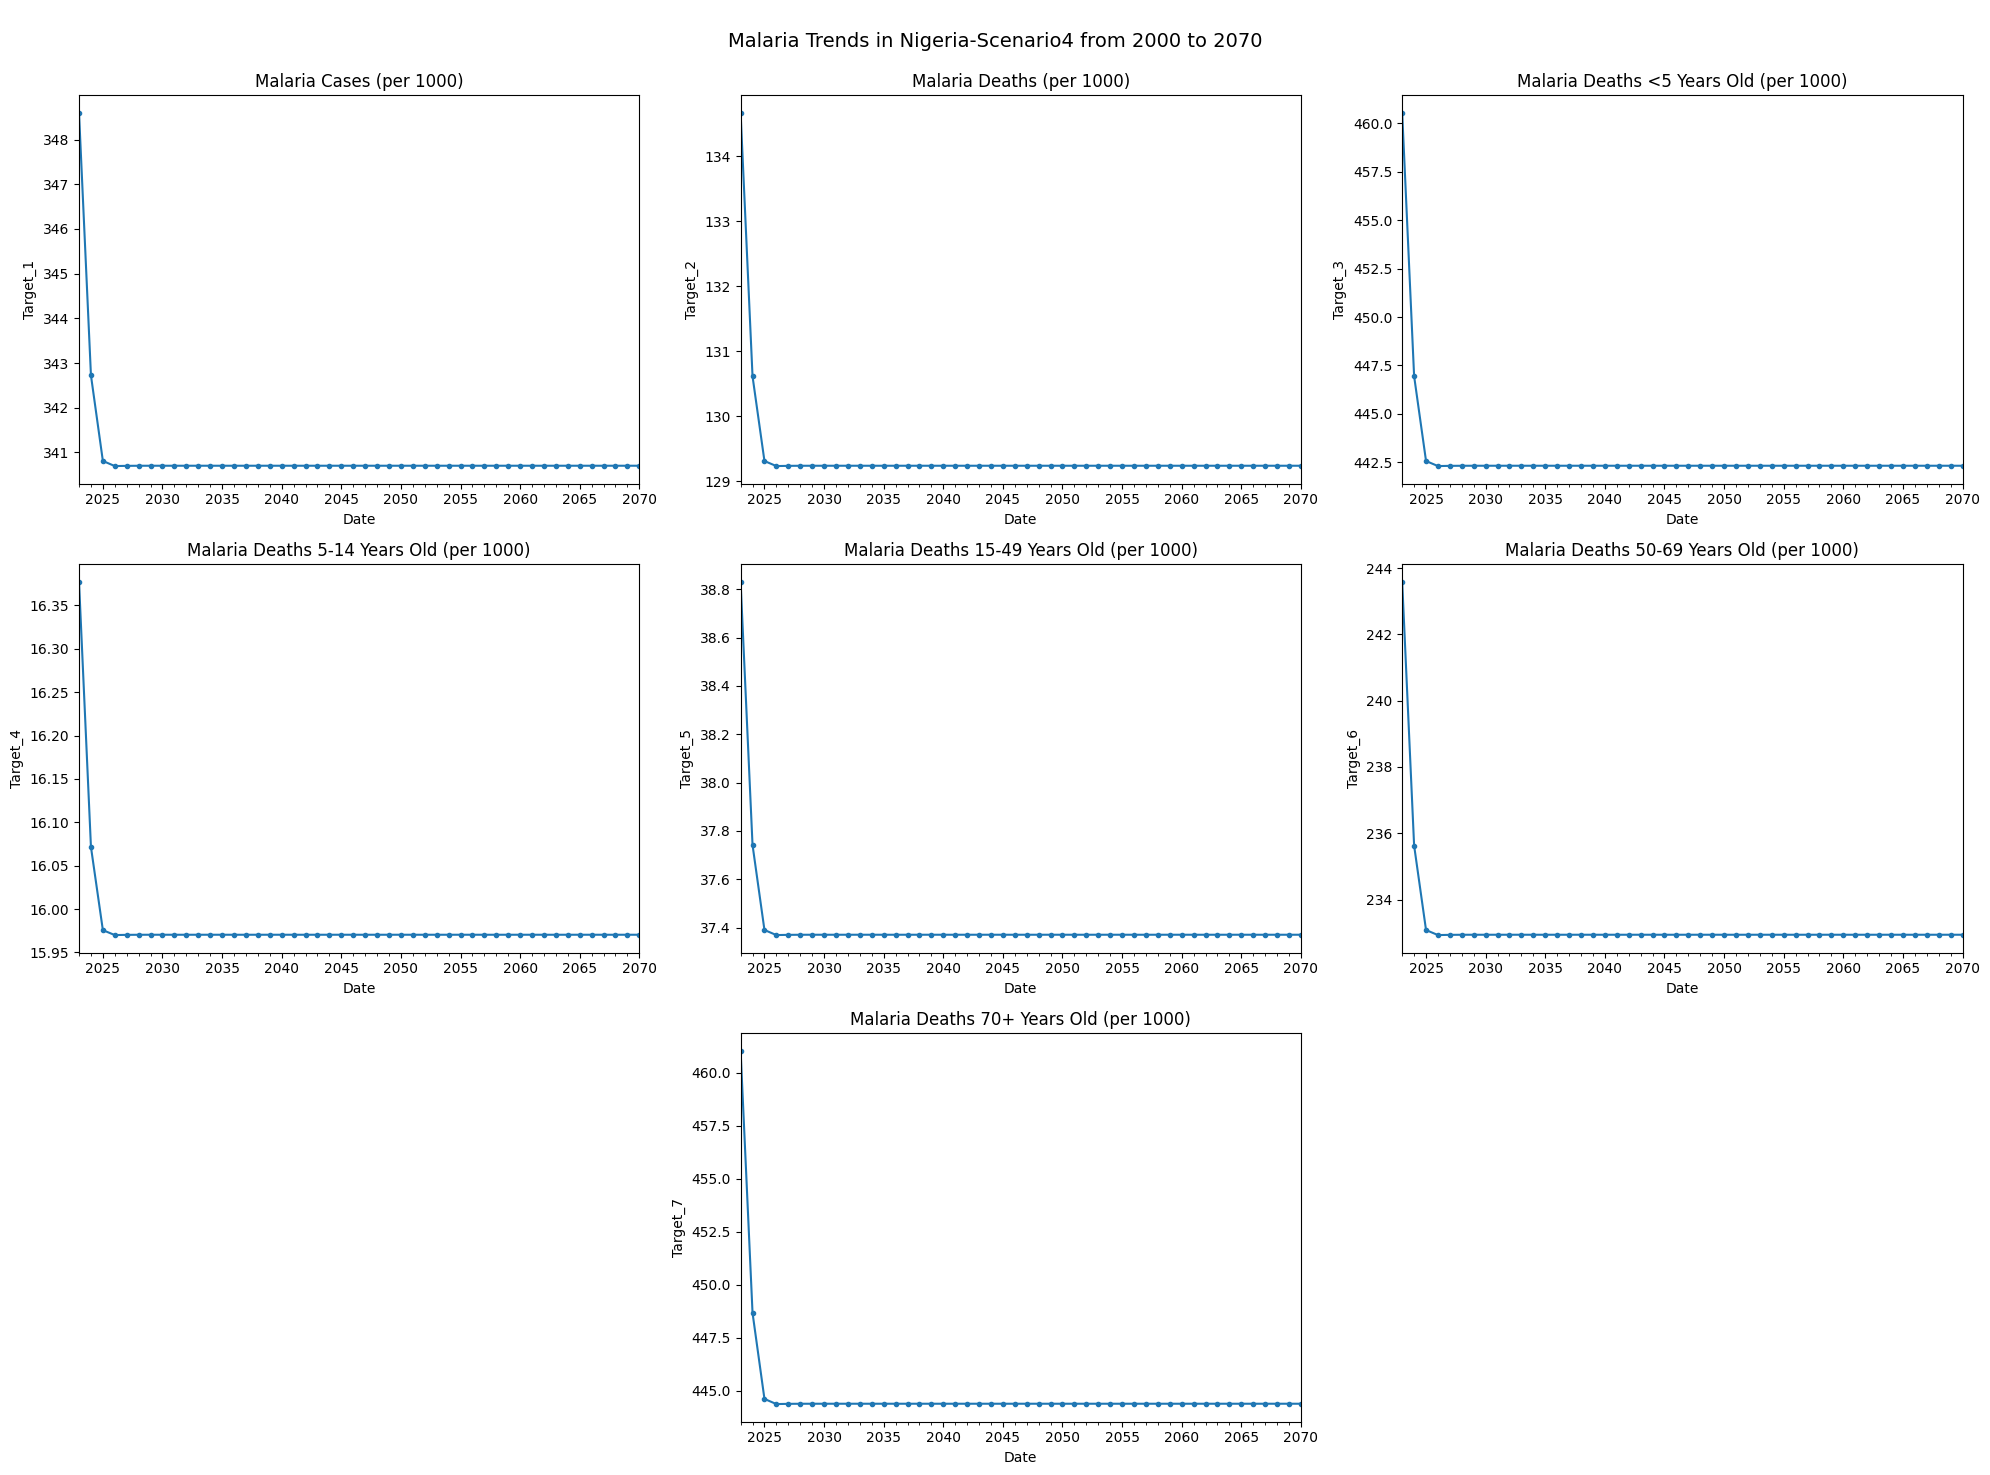

In [63]:
plotmaker.serve_country_predictions(
    data=total_predicted_data[total_predicted_data.Predicted == 1], 
    country="Nigeria-Scenario4",
    targets_list = list(targets_dict.keys()) ,
    target_names = list(targets_dict.values()),
    nrows=3,
    ncols=3, 
    figsize=(20, 15), 
    nfigs=7, 
    centered=True
)

In [64]:
total_predicted_data.loc[["2023-12-31", "2070-12-31"]][target_columns].pct_change()

,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7
2023-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2070-12-31,-0.022646,-0.040282,-0.039534,-0.024831,-0.037601,-0.043679,-0.036108
